## Collaborative Filtering on MovieLens 10M dataset
Authors: (USRMODL S12)
- Christopher Lim
- Kyle Kenneth Chua
- Jethro Tsai

## Importing the Libraries

Loading the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Loading the data preparation and model evaluation libraries

In [2]:
from sklearn.model_selection import train_test_split

from mse import mse

import time

## Importing the Datasets

In [3]:
movies = pd.read_csv('./input/movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('./input/rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
df = movies.merge(ratings, how="left", on="movieId")
df.head()

del movies
del ratings

## Exploratory Data Analysis

### Columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000797 entries, 0 to 20000796
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


In [7]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
mean_num_ratings = df.groupby('userId').count()['movieId'].mean()

print('Number of users:', n_users)   # 5000
print('Number of movies:', n_movies) # 1000
print('Number of ratings:', len(df))
print('Average number of ratings per user:', mean_num_ratings)

Number of users: 138493
Number of movies: 27278
Number of ratings: 20000797
Average number of ratings per user: 144.4135299257002


<AxesSubplot:xlabel='userId'>

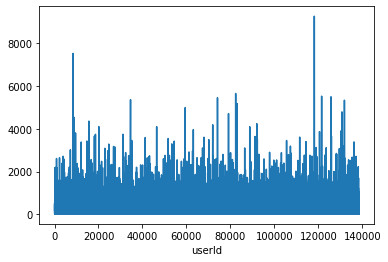

In [8]:
df.groupby('userId').count()['movieId'].plot()

<AxesSubplot:xlabel='movieId'>

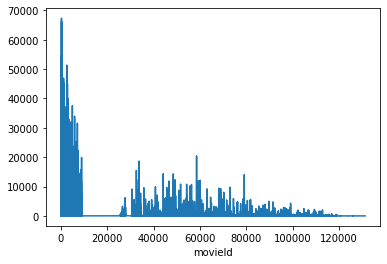

In [9]:
df.groupby('movieId').count()['userId'].plot()

In [10]:
print('Min Rating:', df['rating'].min())
print('Max Rating:', df['rating'].max())

Min Rating: 0.5
Max Rating: 5.0


## Data Preprocessing

### Drop missing user ids

In [11]:
df = df.dropna(subset=["userId"], axis=0)
len(df)

20000263

### Removes `genres`, `timestamp`, and `title` column

In [12]:
# Remove column name 'genres', 'timestamp' and 'title'
df = df.drop(['genres', 'timestamp', 'title'], axis=1)
df['userId'] = df['userId'].astype(int)
df.head()

,movieId,userId,rating
0,1,3,4.0
1,1,6,5.0
2,1,8,4.0
3,1,10,4.0
4,1,11,4.5


### Filter to top 1,000 movies and top 1,000 users

In [13]:
n_users = 1000
n_movies = 1000

In [14]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df['userId'].value_counts().head(n_users).index  # top 1,000 users with the most number of ratings

top_df = df[(df['movieId'].isin(titles) & df['userId'].isin(users))]
top_df.head()

,movieId,userId,rating
56,1,156,5.0
71,1,208,4.0
123,1,359,5.0
186,1,572,5.0
190,1,586,2.5


In [15]:
print('Number of users:', top_df['userId'].nunique())
print('Number of movies:', top_df['movieId'].nunique()) 
print('Number of ratings:', len(top_df))
print('Average number of ratings per user:', top_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 627078
Average number of ratings per user: 627.078


#### Convert table format into user-item matrix (utility matrix) format 

In [16]:
top_um= top_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(top_um) / top_um.size) * 100

print('Shape:', top_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 37.29%


### Filter to top 1,000 movies and 1,000 random users

In [17]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df.groupby('userId').count().sample(n=n_users, random_state=0).index

random_df = df[df['movieId'].isin(titles)][df['userId'].isin(users)]
random_df.head()

del df

In [18]:
print('Number of users:', random_df['userId'].nunique())
print('Number of movies:', random_df['movieId'].nunique())
print('Number of ratings:', len(random_df))
print('Average number of ratings per user:', random_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 97366
Average number of ratings per user: 97.366


#### Convert table format into user-item matrix (utility matrix) format 

In [19]:
random_um= random_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(random_um) / random_um.size) * 100

print('Shape:', random_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 90.26%


### Get MSE on avg rating per user and avg rating per movie

In [20]:
utility_matrices = [top_um, random_um]

for um in utility_matrices:
    average_rating_per_user = [np.mean(row[row > 0]) for row in um]
    print('MSE based on average user rating:', np.sum([np.sum(np.square(row[row > 0] - average_rating_per_user[i])) for i, row in enumerate(um)]) / len(um[um > 0]))
    
    average_rating_per_movie = [np.mean(column[column > 0]) for column in um.T]
    print('MSE based on average movie rating:', np.sum([np.sum(np.square(column[column > 0] - average_rating_per_user[i])) for i, column in enumerate(um.T)]) / len(um[um > 0]))
    
    print('Unique values:', np.unique(um))
    print('-' * 20)

MSE based on average user rating: 0.8692040703070432
MSE based on average movie rating: 1.184244324470002
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------
MSE based on average user rating: 0.8742411846794569
MSE based on average movie rating: 1.2724553809851489
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------


### Convert utility matrix ratings from 0 until 5 to -1 until 1 
[0] values means missing values to be converted to -1  
[0.5, 1, 1.5, 2] values means low ratings to be converted to 0 (labeled as bad ratings)  
[2.5, 3, 3.5, 4, 4.5, 5] values means high ratings to be converted to 1 (labeled as good ratings)

In [21]:
normalized_utility_matrices = []
for i, um in enumerate(utility_matrices):
    normalized_utility_matrices.append(um / 5)
    
    print(np.unique(normalized_utility_matrices[i]))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


## Models

### Matrix Factorization/UV Decomposition Model

#### Importing the Matrix Factorization Model

In [22]:
from matrix_factorization import MF

#### Training

In [24]:
training_results = []
mf_models = []

for i in range(len(utility_matrices)):
    # Initialize the Matrix Factorization model
    mf = MF(utility_matrices[i], 3, alpha=0.005, beta=0.002, iterations=150)
    
    start = time.perf_counter()
    
    # Trains the model
    training_result = mf.train()
    
    end = time.perf_counter()
    
    print('Time it took to train: %.4fs' % (end - start))
    
    # Stores the model
    mf_models.append(mf)
    
    # Stores the results
    training_results.append(training_result)

Epoch: 1 ; error = 0.6694
Epoch: 2 ; error = 0.6604
Epoch: 3 ; error = 0.6566
Epoch: 4 ; error = 0.6523
Epoch: 5 ; error = 0.6435
Epoch: 6 ; error = 0.6275
Epoch: 7 ; error = 0.6111
Epoch: 8 ; error = 0.6019
Epoch: 9 ; error = 0.5972
Epoch: 10 ; error = 0.5938
Epoch: 11 ; error = 0.5907
Epoch: 12 ; error = 0.5878
Epoch: 13 ; error = 0.5851
Epoch: 14 ; error = 0.5824
Epoch: 15 ; error = 0.5800
Epoch: 16 ; error = 0.5780
Epoch: 17 ; error = 0.5763
Epoch: 18 ; error = 0.5749
Epoch: 19 ; error = 0.5737
Epoch: 20 ; error = 0.5728
Epoch: 21 ; error = 0.5719
Epoch: 22 ; error = 0.5711
Epoch: 23 ; error = 0.5704
Epoch: 24 ; error = 0.5697
Epoch: 25 ; error = 0.5689
Epoch: 26 ; error = 0.5683
Epoch: 27 ; error = 0.5676
Epoch: 28 ; error = 0.5670
Epoch: 29 ; error = 0.5662
Epoch: 30 ; error = 0.5657
Epoch: 31 ; error = 0.5650
Epoch: 32 ; error = 0.5643
Epoch: 33 ; error = 0.5638
Epoch: 34 ; error = 0.5633
Epoch: 35 ; error = 0.5628
Epoch: 36 ; error = 0.5625
Epoch: 37 ; error = 0.5621
Epoch: 38 

#### Visualizing the training errors

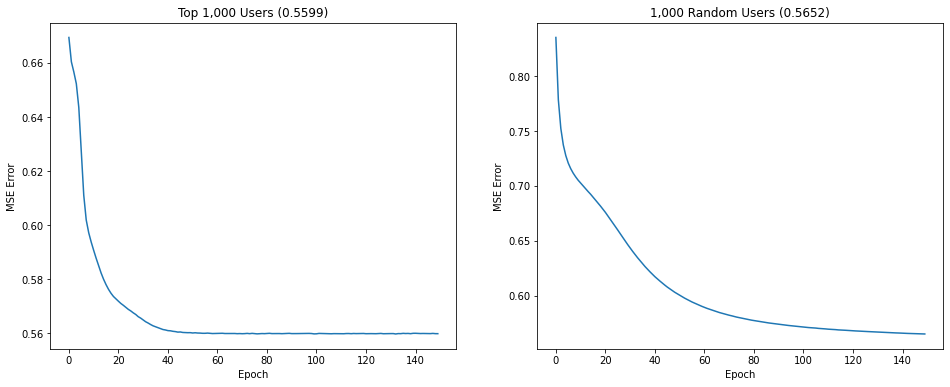

In [51]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i in range(len(utility_matrices)):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(training_results[i]).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Error")
    plt.title(titles[i] + (' (%.4f)' % (training_results[i][-1])))

plt.show()

#### Saving the models
Save the models so that it doesn't have to be trained again.

In [28]:
import pickle 
# models will be saved on a .pkl format (pickle files)
filenames = ['./output/top_mf_model.pkl', './output/random_mf_model.pkl']

for i in range(len(filenames)):
    pickle.dump(mf_models[i], open(filenames[i], 'wb'))

In [30]:
mf_models = []

for filename in filenames:
    mf_models.append(pickle.load(open(filename, 'rb')))

#### Random visual test [TODO]
3 random users will be randomly chosen to compare their actual and predicted results visually

In [35]:
utility_matrices[0]

array([[5. , 5. , 2. , ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 4. , 3. , 4.5],
       [5. , 0. , 0. , ..., 0. , 4. , 0. ],
       ...,
       [5. , 3. , 4. , ..., 0. , 0. , 0. ],
       [3. , 2. , 2. , ..., 4.5, 3.5, 3. ],
       [5. , 3. , 0. , ..., 4.5, 4.5, 5. ]], dtype=float32)

In [36]:
mf_models[0].full_matrix()

array([[4.60697777, 4.04008117, 3.81529407, ..., 4.40338261, 3.99731501,
        4.7056698 ],
       [4.25314389, 2.57713541, 2.40448367, ..., 4.00638653, 3.54877137,
        3.98046281],
       [4.36821976, 3.32816326, 3.18465299, ..., 3.95491308, 3.5800346 ,
        4.12568973],
       ...,
       [4.21163506, 2.44951168, 2.35353997, ..., 3.70351134, 3.27332121,
        3.67539937],
       [3.31272931, 2.30813333, 2.03376482, ..., 3.5454431 , 3.39498468,
        3.58014313],
       [4.5152911 , 3.01315514, 2.81319672, ..., 4.52425621, 4.33803272,
        4.44118557]])

### Random Boltzmann Machine Models
https://github.com/echen/restricted-boltzmann-machines

#### Importing the RBM Model

In [22]:
from rbm import RBM

Instructions for updating:
non-resource variables are not supported in the long term


#### Training the RBM Model

In [26]:
data = []

for um in normalized_utility_matrices:
    # Define the parameters of the RBMs we will train
    rbm=RBM(n_users, n_movies, learning_rate=0.01, epochs=2000, batch_size=100)
    
    start = time.perf_counter()
    
    # Trains the model
    training_result = rbm.train(um)
    
    end = time.perf_counter()
    
    print('Time it took to train: %.4fs' % (end - start))
    
    output, predicted, _ = rbm.rbm_output(um)
    
    data.append({
        'model': rbm,
        'output': output,
        'predicted': predicted,
        'training_result': training_result
    })

Epoch: 0 ; reconstruction error: 0.3188
Epoch: 1 ; reconstruction error: 0.3201
Epoch: 2 ; reconstruction error: 0.3189
Epoch: 3 ; reconstruction error: 0.3171
Epoch: 4 ; reconstruction error: 0.3179
Epoch: 5 ; reconstruction error: 0.3168
Epoch: 6 ; reconstruction error: 0.3165
Epoch: 7 ; reconstruction error: 0.3167
Epoch: 8 ; reconstruction error: 0.3145
Epoch: 9 ; reconstruction error: 0.3142
Epoch: 10 ; reconstruction error: 0.3146
Epoch: 11 ; reconstruction error: 0.3131
Epoch: 12 ; reconstruction error: 0.3128
Epoch: 13 ; reconstruction error: 0.3110
Epoch: 14 ; reconstruction error: 0.3107
Epoch: 15 ; reconstruction error: 0.3082
Epoch: 16 ; reconstruction error: 0.3083
Epoch: 17 ; reconstruction error: 0.3067
Epoch: 18 ; reconstruction error: 0.3042
Epoch: 19 ; reconstruction error: 0.3031
Epoch: 20 ; reconstruction error: 0.3020
Epoch: 21 ; reconstruction error: 0.3011
Epoch: 22 ; reconstruction error: 0.3008
Epoch: 23 ; reconstruction error: 0.3000
Epoch: 24 ; reconstruction

Epoch: 199 ; reconstruction error: 0.2744
Epoch: 200 ; reconstruction error: 0.2735
Epoch: 201 ; reconstruction error: 0.2740
Epoch: 202 ; reconstruction error: 0.2734
Epoch: 203 ; reconstruction error: 0.2732
Epoch: 204 ; reconstruction error: 0.2738
Epoch: 205 ; reconstruction error: 0.2736
Epoch: 206 ; reconstruction error: 0.2739
Epoch: 207 ; reconstruction error: 0.2736
Epoch: 208 ; reconstruction error: 0.2737
Epoch: 209 ; reconstruction error: 0.2740
Epoch: 210 ; reconstruction error: 0.2739
Epoch: 211 ; reconstruction error: 0.2736
Epoch: 212 ; reconstruction error: 0.2738
Epoch: 213 ; reconstruction error: 0.2728
Epoch: 214 ; reconstruction error: 0.2729
Epoch: 215 ; reconstruction error: 0.2735
Epoch: 216 ; reconstruction error: 0.2731
Epoch: 217 ; reconstruction error: 0.2735
Epoch: 218 ; reconstruction error: 0.2733
Epoch: 219 ; reconstruction error: 0.2733
Epoch: 220 ; reconstruction error: 0.2719
Epoch: 221 ; reconstruction error: 0.2728
Epoch: 222 ; reconstruction error:

Epoch: 395 ; reconstruction error: 0.2672
Epoch: 396 ; reconstruction error: 0.2663
Epoch: 397 ; reconstruction error: 0.2670
Epoch: 398 ; reconstruction error: 0.2666
Epoch: 399 ; reconstruction error: 0.2665
Epoch: 400 ; reconstruction error: 0.2671
Epoch: 401 ; reconstruction error: 0.2664
Epoch: 402 ; reconstruction error: 0.2668
Epoch: 403 ; reconstruction error: 0.2668
Epoch: 404 ; reconstruction error: 0.2660
Epoch: 405 ; reconstruction error: 0.2658
Epoch: 406 ; reconstruction error: 0.2667
Epoch: 407 ; reconstruction error: 0.2661
Epoch: 408 ; reconstruction error: 0.2656
Epoch: 409 ; reconstruction error: 0.2665
Epoch: 410 ; reconstruction error: 0.2663
Epoch: 411 ; reconstruction error: 0.2658
Epoch: 412 ; reconstruction error: 0.2660
Epoch: 413 ; reconstruction error: 0.2659
Epoch: 414 ; reconstruction error: 0.2661
Epoch: 415 ; reconstruction error: 0.2657
Epoch: 416 ; reconstruction error: 0.2650
Epoch: 417 ; reconstruction error: 0.2665
Epoch: 418 ; reconstruction error:

Epoch: 591 ; reconstruction error: 0.2619
Epoch: 592 ; reconstruction error: 0.2617
Epoch: 593 ; reconstruction error: 0.2615
Epoch: 594 ; reconstruction error: 0.2618
Epoch: 595 ; reconstruction error: 0.2616
Epoch: 596 ; reconstruction error: 0.2617
Epoch: 597 ; reconstruction error: 0.2622
Epoch: 598 ; reconstruction error: 0.2614
Epoch: 599 ; reconstruction error: 0.2613
Epoch: 600 ; reconstruction error: 0.2617
Epoch: 601 ; reconstruction error: 0.2612
Epoch: 602 ; reconstruction error: 0.2614
Epoch: 603 ; reconstruction error: 0.2604
Epoch: 604 ; reconstruction error: 0.2620
Epoch: 605 ; reconstruction error: 0.2611
Epoch: 606 ; reconstruction error: 0.2619
Epoch: 607 ; reconstruction error: 0.2612
Epoch: 608 ; reconstruction error: 0.2613
Epoch: 609 ; reconstruction error: 0.2609
Epoch: 610 ; reconstruction error: 0.2614
Epoch: 611 ; reconstruction error: 0.2609
Epoch: 612 ; reconstruction error: 0.2607
Epoch: 613 ; reconstruction error: 0.2620
Epoch: 614 ; reconstruction error:

Epoch: 788 ; reconstruction error: 0.2574
Epoch: 789 ; reconstruction error: 0.2566
Epoch: 790 ; reconstruction error: 0.2571
Epoch: 791 ; reconstruction error: 0.2566
Epoch: 792 ; reconstruction error: 0.2568
Epoch: 793 ; reconstruction error: 0.2571
Epoch: 794 ; reconstruction error: 0.2567
Epoch: 795 ; reconstruction error: 0.2570
Epoch: 796 ; reconstruction error: 0.2563
Epoch: 797 ; reconstruction error: 0.2568
Epoch: 798 ; reconstruction error: 0.2573
Epoch: 799 ; reconstruction error: 0.2575
Epoch: 800 ; reconstruction error: 0.2568
Epoch: 801 ; reconstruction error: 0.2570
Epoch: 802 ; reconstruction error: 0.2571
Epoch: 803 ; reconstruction error: 0.2567
Epoch: 804 ; reconstruction error: 0.2572
Epoch: 805 ; reconstruction error: 0.2574
Epoch: 806 ; reconstruction error: 0.2569
Epoch: 807 ; reconstruction error: 0.2569
Epoch: 808 ; reconstruction error: 0.2567
Epoch: 809 ; reconstruction error: 0.2569
Epoch: 810 ; reconstruction error: 0.2571
Epoch: 811 ; reconstruction error:

Epoch: 984 ; reconstruction error: 0.2531
Epoch: 985 ; reconstruction error: 0.2540
Epoch: 986 ; reconstruction error: 0.2535
Epoch: 987 ; reconstruction error: 0.2532
Epoch: 988 ; reconstruction error: 0.2536
Epoch: 989 ; reconstruction error: 0.2539
Epoch: 990 ; reconstruction error: 0.2541
Epoch: 991 ; reconstruction error: 0.2525
Epoch: 992 ; reconstruction error: 0.2546
Epoch: 993 ; reconstruction error: 0.2537
Epoch: 994 ; reconstruction error: 0.2539
Epoch: 995 ; reconstruction error: 0.2533
Epoch: 996 ; reconstruction error: 0.2529
Epoch: 997 ; reconstruction error: 0.2533
Epoch: 998 ; reconstruction error: 0.2532
Epoch: 999 ; reconstruction error: 0.2535
Epoch: 1000 ; reconstruction error: 0.2532
Epoch: 1001 ; reconstruction error: 0.2531
Epoch: 1002 ; reconstruction error: 0.2532
Epoch: 1003 ; reconstruction error: 0.2532
Epoch: 1004 ; reconstruction error: 0.2533
Epoch: 1005 ; reconstruction error: 0.2524
Epoch: 1006 ; reconstruction error: 0.2530
Epoch: 1007 ; reconstructio

Epoch: 1176 ; reconstruction error: 0.2492
Epoch: 1177 ; reconstruction error: 0.2499
Epoch: 1178 ; reconstruction error: 0.2495
Epoch: 1179 ; reconstruction error: 0.2496
Epoch: 1180 ; reconstruction error: 0.2503
Epoch: 1181 ; reconstruction error: 0.2489
Epoch: 1182 ; reconstruction error: 0.2502
Epoch: 1183 ; reconstruction error: 0.2489
Epoch: 1184 ; reconstruction error: 0.2498
Epoch: 1185 ; reconstruction error: 0.2490
Epoch: 1186 ; reconstruction error: 0.2497
Epoch: 1187 ; reconstruction error: 0.2499
Epoch: 1188 ; reconstruction error: 0.2498
Epoch: 1189 ; reconstruction error: 0.2489
Epoch: 1190 ; reconstruction error: 0.2491
Epoch: 1191 ; reconstruction error: 0.2498
Epoch: 1192 ; reconstruction error: 0.2495
Epoch: 1193 ; reconstruction error: 0.2498
Epoch: 1194 ; reconstruction error: 0.2502
Epoch: 1195 ; reconstruction error: 0.2497
Epoch: 1196 ; reconstruction error: 0.2496
Epoch: 1197 ; reconstruction error: 0.2494
Epoch: 1198 ; reconstruction error: 0.2498
Epoch: 1199

Epoch: 1368 ; reconstruction error: 0.2463
Epoch: 1369 ; reconstruction error: 0.2468
Epoch: 1370 ; reconstruction error: 0.2457
Epoch: 1371 ; reconstruction error: 0.2468
Epoch: 1372 ; reconstruction error: 0.2471
Epoch: 1373 ; reconstruction error: 0.2459
Epoch: 1374 ; reconstruction error: 0.2470
Epoch: 1375 ; reconstruction error: 0.2468
Epoch: 1376 ; reconstruction error: 0.2466
Epoch: 1377 ; reconstruction error: 0.2458
Epoch: 1378 ; reconstruction error: 0.2466
Epoch: 1379 ; reconstruction error: 0.2463
Epoch: 1380 ; reconstruction error: 0.2465
Epoch: 1381 ; reconstruction error: 0.2468
Epoch: 1382 ; reconstruction error: 0.2461
Epoch: 1383 ; reconstruction error: 0.2461
Epoch: 1384 ; reconstruction error: 0.2471
Epoch: 1385 ; reconstruction error: 0.2464
Epoch: 1386 ; reconstruction error: 0.2459
Epoch: 1387 ; reconstruction error: 0.2472
Epoch: 1388 ; reconstruction error: 0.2466
Epoch: 1389 ; reconstruction error: 0.2462
Epoch: 1390 ; reconstruction error: 0.2458
Epoch: 1391

Epoch: 1560 ; reconstruction error: 0.2429
Epoch: 1561 ; reconstruction error: 0.2433
Epoch: 1562 ; reconstruction error: 0.2435
Epoch: 1563 ; reconstruction error: 0.2437
Epoch: 1564 ; reconstruction error: 0.2434
Epoch: 1565 ; reconstruction error: 0.2439
Epoch: 1566 ; reconstruction error: 0.2442
Epoch: 1567 ; reconstruction error: 0.2426
Epoch: 1568 ; reconstruction error: 0.2429
Epoch: 1569 ; reconstruction error: 0.2436
Epoch: 1570 ; reconstruction error: 0.2439
Epoch: 1571 ; reconstruction error: 0.2437
Epoch: 1572 ; reconstruction error: 0.2438
Epoch: 1573 ; reconstruction error: 0.2441
Epoch: 1574 ; reconstruction error: 0.2433
Epoch: 1575 ; reconstruction error: 0.2431
Epoch: 1576 ; reconstruction error: 0.2435
Epoch: 1577 ; reconstruction error: 0.2426
Epoch: 1578 ; reconstruction error: 0.2427
Epoch: 1579 ; reconstruction error: 0.2433
Epoch: 1580 ; reconstruction error: 0.2433
Epoch: 1581 ; reconstruction error: 0.2429
Epoch: 1582 ; reconstruction error: 0.2432
Epoch: 1583

Epoch: 1752 ; reconstruction error: 0.2408
Epoch: 1753 ; reconstruction error: 0.2407
Epoch: 1754 ; reconstruction error: 0.2406
Epoch: 1755 ; reconstruction error: 0.2402
Epoch: 1756 ; reconstruction error: 0.2408
Epoch: 1757 ; reconstruction error: 0.2405
Epoch: 1758 ; reconstruction error: 0.2410
Epoch: 1759 ; reconstruction error: 0.2404
Epoch: 1760 ; reconstruction error: 0.2402
Epoch: 1761 ; reconstruction error: 0.2403
Epoch: 1762 ; reconstruction error: 0.2410
Epoch: 1763 ; reconstruction error: 0.2407
Epoch: 1764 ; reconstruction error: 0.2407
Epoch: 1765 ; reconstruction error: 0.2411
Epoch: 1766 ; reconstruction error: 0.2403
Epoch: 1767 ; reconstruction error: 0.2398
Epoch: 1768 ; reconstruction error: 0.2407
Epoch: 1769 ; reconstruction error: 0.2399
Epoch: 1770 ; reconstruction error: 0.2401
Epoch: 1771 ; reconstruction error: 0.2402
Epoch: 1772 ; reconstruction error: 0.2407
Epoch: 1773 ; reconstruction error: 0.2410
Epoch: 1774 ; reconstruction error: 0.2405
Epoch: 1775

Epoch: 1944 ; reconstruction error: 0.2380
Epoch: 1945 ; reconstruction error: 0.2377
Epoch: 1946 ; reconstruction error: 0.2381
Epoch: 1947 ; reconstruction error: 0.2383
Epoch: 1948 ; reconstruction error: 0.2387
Epoch: 1949 ; reconstruction error: 0.2377
Epoch: 1950 ; reconstruction error: 0.2378
Epoch: 1951 ; reconstruction error: 0.2373
Epoch: 1952 ; reconstruction error: 0.2375
Epoch: 1953 ; reconstruction error: 0.2373
Epoch: 1954 ; reconstruction error: 0.2376
Epoch: 1955 ; reconstruction error: 0.2375
Epoch: 1956 ; reconstruction error: 0.2374
Epoch: 1957 ; reconstruction error: 0.2381
Epoch: 1958 ; reconstruction error: 0.2374
Epoch: 1959 ; reconstruction error: 0.2378
Epoch: 1960 ; reconstruction error: 0.2377
Epoch: 1961 ; reconstruction error: 0.2371
Epoch: 1962 ; reconstruction error: 0.2378
Epoch: 1963 ; reconstruction error: 0.2373
Epoch: 1964 ; reconstruction error: 0.2376
Epoch: 1965 ; reconstruction error: 0.2374
Epoch: 1966 ; reconstruction error: 0.2380
Epoch: 1967

Epoch: 140 ; reconstruction error: 0.4223
Epoch: 141 ; reconstruction error: 0.4213
Epoch: 142 ; reconstruction error: 0.4214
Epoch: 143 ; reconstruction error: 0.4214
Epoch: 144 ; reconstruction error: 0.4211
Epoch: 145 ; reconstruction error: 0.4200
Epoch: 146 ; reconstruction error: 0.4188
Epoch: 147 ; reconstruction error: 0.4203
Epoch: 148 ; reconstruction error: 0.4195
Epoch: 149 ; reconstruction error: 0.4173
Epoch: 150 ; reconstruction error: 0.4176
Epoch: 151 ; reconstruction error: 0.4188
Epoch: 152 ; reconstruction error: 0.4180
Epoch: 153 ; reconstruction error: 0.4198
Epoch: 154 ; reconstruction error: 0.4190
Epoch: 155 ; reconstruction error: 0.4167
Epoch: 156 ; reconstruction error: 0.4180
Epoch: 157 ; reconstruction error: 0.4167
Epoch: 158 ; reconstruction error: 0.4190
Epoch: 159 ; reconstruction error: 0.4165
Epoch: 160 ; reconstruction error: 0.4175
Epoch: 161 ; reconstruction error: 0.4162
Epoch: 162 ; reconstruction error: 0.4173
Epoch: 163 ; reconstruction error:

Epoch: 337 ; reconstruction error: 0.3925
Epoch: 338 ; reconstruction error: 0.3940
Epoch: 339 ; reconstruction error: 0.3920
Epoch: 340 ; reconstruction error: 0.3939
Epoch: 341 ; reconstruction error: 0.3920
Epoch: 342 ; reconstruction error: 0.3905
Epoch: 343 ; reconstruction error: 0.3908
Epoch: 344 ; reconstruction error: 0.3913
Epoch: 345 ; reconstruction error: 0.3906
Epoch: 346 ; reconstruction error: 0.3913
Epoch: 347 ; reconstruction error: 0.3909
Epoch: 348 ; reconstruction error: 0.3928
Epoch: 349 ; reconstruction error: 0.3893
Epoch: 350 ; reconstruction error: 0.3906
Epoch: 351 ; reconstruction error: 0.3912
Epoch: 352 ; reconstruction error: 0.3923
Epoch: 353 ; reconstruction error: 0.3910
Epoch: 354 ; reconstruction error: 0.3916
Epoch: 355 ; reconstruction error: 0.3913
Epoch: 356 ; reconstruction error: 0.3895
Epoch: 357 ; reconstruction error: 0.3914
Epoch: 358 ; reconstruction error: 0.3895
Epoch: 359 ; reconstruction error: 0.3906
Epoch: 360 ; reconstruction error:

Epoch: 533 ; reconstruction error: 0.3769
Epoch: 534 ; reconstruction error: 0.3762
Epoch: 535 ; reconstruction error: 0.3756
Epoch: 536 ; reconstruction error: 0.3757
Epoch: 537 ; reconstruction error: 0.3757
Epoch: 538 ; reconstruction error: 0.3751
Epoch: 539 ; reconstruction error: 0.3743
Epoch: 540 ; reconstruction error: 0.3743
Epoch: 541 ; reconstruction error: 0.3738
Epoch: 542 ; reconstruction error: 0.3745
Epoch: 543 ; reconstruction error: 0.3754
Epoch: 544 ; reconstruction error: 0.3758
Epoch: 545 ; reconstruction error: 0.3746
Epoch: 546 ; reconstruction error: 0.3742
Epoch: 547 ; reconstruction error: 0.3747
Epoch: 548 ; reconstruction error: 0.3757
Epoch: 549 ; reconstruction error: 0.3758
Epoch: 550 ; reconstruction error: 0.3751
Epoch: 551 ; reconstruction error: 0.3738
Epoch: 552 ; reconstruction error: 0.3759
Epoch: 553 ; reconstruction error: 0.3733
Epoch: 554 ; reconstruction error: 0.3748
Epoch: 555 ; reconstruction error: 0.3762
Epoch: 556 ; reconstruction error:

Epoch: 729 ; reconstruction error: 0.3652
Epoch: 730 ; reconstruction error: 0.3650
Epoch: 731 ; reconstruction error: 0.3631
Epoch: 732 ; reconstruction error: 0.3635
Epoch: 733 ; reconstruction error: 0.3642
Epoch: 734 ; reconstruction error: 0.3633
Epoch: 735 ; reconstruction error: 0.3638
Epoch: 736 ; reconstruction error: 0.3629
Epoch: 737 ; reconstruction error: 0.3624
Epoch: 738 ; reconstruction error: 0.3647
Epoch: 739 ; reconstruction error: 0.3604
Epoch: 740 ; reconstruction error: 0.3620
Epoch: 741 ; reconstruction error: 0.3621
Epoch: 742 ; reconstruction error: 0.3627
Epoch: 743 ; reconstruction error: 0.3621
Epoch: 744 ; reconstruction error: 0.3622
Epoch: 745 ; reconstruction error: 0.3629
Epoch: 746 ; reconstruction error: 0.3631
Epoch: 747 ; reconstruction error: 0.3635
Epoch: 748 ; reconstruction error: 0.3612
Epoch: 749 ; reconstruction error: 0.3610
Epoch: 750 ; reconstruction error: 0.3630
Epoch: 751 ; reconstruction error: 0.3627
Epoch: 752 ; reconstruction error:

Epoch: 925 ; reconstruction error: 0.3527
Epoch: 926 ; reconstruction error: 0.3539
Epoch: 927 ; reconstruction error: 0.3518
Epoch: 928 ; reconstruction error: 0.3517
Epoch: 929 ; reconstruction error: 0.3524
Epoch: 930 ; reconstruction error: 0.3511
Epoch: 931 ; reconstruction error: 0.3506
Epoch: 932 ; reconstruction error: 0.3530
Epoch: 933 ; reconstruction error: 0.3511
Epoch: 934 ; reconstruction error: 0.3518
Epoch: 935 ; reconstruction error: 0.3516
Epoch: 936 ; reconstruction error: 0.3525
Epoch: 937 ; reconstruction error: 0.3533
Epoch: 938 ; reconstruction error: 0.3507
Epoch: 939 ; reconstruction error: 0.3512
Epoch: 940 ; reconstruction error: 0.3516
Epoch: 941 ; reconstruction error: 0.3509
Epoch: 942 ; reconstruction error: 0.3515
Epoch: 943 ; reconstruction error: 0.3518
Epoch: 944 ; reconstruction error: 0.3525
Epoch: 945 ; reconstruction error: 0.3507
Epoch: 946 ; reconstruction error: 0.3516
Epoch: 947 ; reconstruction error: 0.3522
Epoch: 948 ; reconstruction error:

Epoch: 1118 ; reconstruction error: 0.3429
Epoch: 1119 ; reconstruction error: 0.3413
Epoch: 1120 ; reconstruction error: 0.3417
Epoch: 1121 ; reconstruction error: 0.3427
Epoch: 1122 ; reconstruction error: 0.3426
Epoch: 1123 ; reconstruction error: 0.3417
Epoch: 1124 ; reconstruction error: 0.3398
Epoch: 1125 ; reconstruction error: 0.3409
Epoch: 1126 ; reconstruction error: 0.3416
Epoch: 1127 ; reconstruction error: 0.3420
Epoch: 1128 ; reconstruction error: 0.3413
Epoch: 1129 ; reconstruction error: 0.3409
Epoch: 1130 ; reconstruction error: 0.3427
Epoch: 1131 ; reconstruction error: 0.3400
Epoch: 1132 ; reconstruction error: 0.3411
Epoch: 1133 ; reconstruction error: 0.3422
Epoch: 1134 ; reconstruction error: 0.3419
Epoch: 1135 ; reconstruction error: 0.3404
Epoch: 1136 ; reconstruction error: 0.3420
Epoch: 1137 ; reconstruction error: 0.3398
Epoch: 1138 ; reconstruction error: 0.3408
Epoch: 1139 ; reconstruction error: 0.3420
Epoch: 1140 ; reconstruction error: 0.3402
Epoch: 1141

Epoch: 1310 ; reconstruction error: 0.3332
Epoch: 1311 ; reconstruction error: 0.3308
Epoch: 1312 ; reconstruction error: 0.3291
Epoch: 1313 ; reconstruction error: 0.3319
Epoch: 1314 ; reconstruction error: 0.3315
Epoch: 1315 ; reconstruction error: 0.3312
Epoch: 1316 ; reconstruction error: 0.3311
Epoch: 1317 ; reconstruction error: 0.3307
Epoch: 1318 ; reconstruction error: 0.3314
Epoch: 1319 ; reconstruction error: 0.3327
Epoch: 1320 ; reconstruction error: 0.3304
Epoch: 1321 ; reconstruction error: 0.3313
Epoch: 1322 ; reconstruction error: 0.3315
Epoch: 1323 ; reconstruction error: 0.3306
Epoch: 1324 ; reconstruction error: 0.3315
Epoch: 1325 ; reconstruction error: 0.3311
Epoch: 1326 ; reconstruction error: 0.3319
Epoch: 1327 ; reconstruction error: 0.3324
Epoch: 1328 ; reconstruction error: 0.3306
Epoch: 1329 ; reconstruction error: 0.3314
Epoch: 1330 ; reconstruction error: 0.3313
Epoch: 1331 ; reconstruction error: 0.3306
Epoch: 1332 ; reconstruction error: 0.3299
Epoch: 1333

Epoch: 1502 ; reconstruction error: 0.3227
Epoch: 1503 ; reconstruction error: 0.3215
Epoch: 1504 ; reconstruction error: 0.3244
Epoch: 1505 ; reconstruction error: 0.3221
Epoch: 1506 ; reconstruction error: 0.3230
Epoch: 1507 ; reconstruction error: 0.3216
Epoch: 1508 ; reconstruction error: 0.3222
Epoch: 1509 ; reconstruction error: 0.3222
Epoch: 1510 ; reconstruction error: 0.3213
Epoch: 1511 ; reconstruction error: 0.3209
Epoch: 1512 ; reconstruction error: 0.3209
Epoch: 1513 ; reconstruction error: 0.3216
Epoch: 1514 ; reconstruction error: 0.3184
Epoch: 1515 ; reconstruction error: 0.3217
Epoch: 1516 ; reconstruction error: 0.3206
Epoch: 1517 ; reconstruction error: 0.3207
Epoch: 1518 ; reconstruction error: 0.3202
Epoch: 1519 ; reconstruction error: 0.3214
Epoch: 1520 ; reconstruction error: 0.3208
Epoch: 1521 ; reconstruction error: 0.3209
Epoch: 1522 ; reconstruction error: 0.3199
Epoch: 1523 ; reconstruction error: 0.3208
Epoch: 1524 ; reconstruction error: 0.3203
Epoch: 1525

Epoch: 1694 ; reconstruction error: 0.3122
Epoch: 1695 ; reconstruction error: 0.3121
Epoch: 1696 ; reconstruction error: 0.3140
Epoch: 1697 ; reconstruction error: 0.3122
Epoch: 1698 ; reconstruction error: 0.3147
Epoch: 1699 ; reconstruction error: 0.3139
Epoch: 1700 ; reconstruction error: 0.3123
Epoch: 1701 ; reconstruction error: 0.3121
Epoch: 1702 ; reconstruction error: 0.3118
Epoch: 1703 ; reconstruction error: 0.3124
Epoch: 1704 ; reconstruction error: 0.3114
Epoch: 1705 ; reconstruction error: 0.3119
Epoch: 1706 ; reconstruction error: 0.3117
Epoch: 1707 ; reconstruction error: 0.3124
Epoch: 1708 ; reconstruction error: 0.3135
Epoch: 1709 ; reconstruction error: 0.3105
Epoch: 1710 ; reconstruction error: 0.3115
Epoch: 1711 ; reconstruction error: 0.3115
Epoch: 1712 ; reconstruction error: 0.3117
Epoch: 1713 ; reconstruction error: 0.3107
Epoch: 1714 ; reconstruction error: 0.3115
Epoch: 1715 ; reconstruction error: 0.3118
Epoch: 1716 ; reconstruction error: 0.3117
Epoch: 1717

Epoch: 1886 ; reconstruction error: 0.3033
Epoch: 1887 ; reconstruction error: 0.3025
Epoch: 1888 ; reconstruction error: 0.3033
Epoch: 1889 ; reconstruction error: 0.3021
Epoch: 1890 ; reconstruction error: 0.3019
Epoch: 1891 ; reconstruction error: 0.3020
Epoch: 1892 ; reconstruction error: 0.3030
Epoch: 1893 ; reconstruction error: 0.3020
Epoch: 1894 ; reconstruction error: 0.3033
Epoch: 1895 ; reconstruction error: 0.3032
Epoch: 1896 ; reconstruction error: 0.3026
Epoch: 1897 ; reconstruction error: 0.3019
Epoch: 1898 ; reconstruction error: 0.3018
Epoch: 1899 ; reconstruction error: 0.3024
Epoch: 1900 ; reconstruction error: 0.3037
Epoch: 1901 ; reconstruction error: 0.3039
Epoch: 1902 ; reconstruction error: 0.3012
Epoch: 1903 ; reconstruction error: 0.3043
Epoch: 1904 ; reconstruction error: 0.3035
Epoch: 1905 ; reconstruction error: 0.3015
Epoch: 1906 ; reconstruction error: 0.3015
Epoch: 1907 ; reconstruction error: 0.3028
Epoch: 1908 ; reconstruction error: 0.3022
Epoch: 1909

#### Visualization Errors

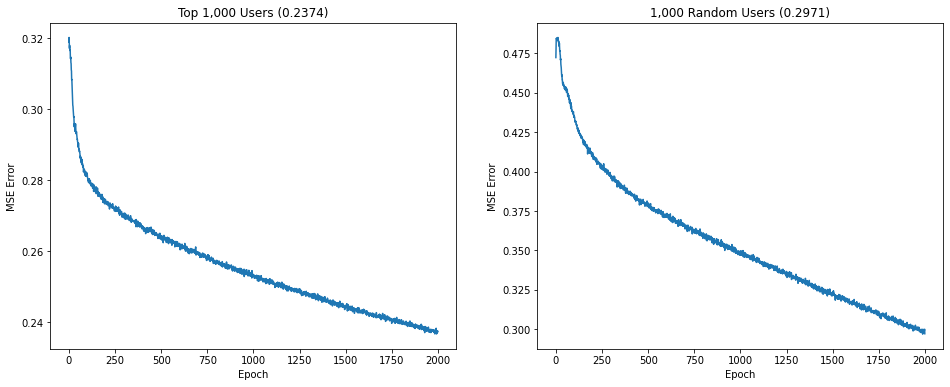

In [28]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i, d in enumerate(data):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(d['training_result']).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Error")
    plt.title(titles[i] + (' (%.4f)' % (d['training_result'][-1])))

plt.show()

#### Saving the models
Save the models so that it doesn't have to be trained again.

In [33]:
import pickle 
# models will be saved on a .pkl format (pickle files)
filenames = ['./output/top_rbm_model.pkl', './output/random_rbm_model.pkl']

for i in range(len(filenames)):
    pickle.dump(data[i]['model'], open(filenames[i], 'wb'))

In [34]:
rbm_models = []

for filename in filenames:
    rbm_models.append(pickle.load(open(filename, 'rb')))

In [35]:
output, visible, hidden = rbm_models[0].rbm_output(normalized_utility_matrices[0])

#### Random visual test [TODO]
3 random users will be randomly chosen to compare their actual and predicted results visually

In [ ]:
# TODO

In [40]:
np.mean(np.square(visible - normalized_utility_matrices[0]))

0.20919514

In [43]:
for i in range(100): 
    print('%.4f - %.4f' % (visible[:1][0][i], normalized_utility_matrices[0][0][i]))

1.0000 - 1.0000
1.0000 - 1.0000
0.0000 - 0.4000
0.0000 - 0.6000
1.0000 - 0.8000
1.0000 - 0.8000
1.0000 - 0.8000
1.0000 - 1.0000
0.0000 - 0.0000
1.0000 - 0.8000
0.0000 - 0.8000
1.0000 - 0.6000
0.0000 - 0.0000
1.0000 - 0.8000
0.0000 - 0.8000
1.0000 - 0.8000
0.0000 - 0.8000
0.0000 - 0.0000
1.0000 - 0.0000
1.0000 - 1.0000
1.0000 - 0.6000
0.0000 - 0.7000
1.0000 - 0.0000
0.0000 - 0.0000
1.0000 - 0.4000
1.0000 - 0.8000
0.0000 - 0.0000
1.0000 - 1.0000
0.0000 - 0.6000
1.0000 - 0.0000
1.0000 - 0.8000
1.0000 - 0.8000
1.0000 - 0.8000
1.0000 - 0.6000
1.0000 - 0.8000
1.0000 - 0.4000
1.0000 - 0.8000
0.0000 - 0.0000
1.0000 - 1.0000
0.0000 - 0.8000
0.0000 - 0.6000
0.0000 - 0.8000
1.0000 - 0.6000
1.0000 - 0.8000
0.0000 - 0.0000
1.0000 - 1.0000
0.0000 - 0.0000
1.0000 - 0.6000
1.0000 - 0.6000
0.0000 - 0.8000
1.0000 - 0.8000
0.0000 - 0.0000
1.0000 - 0.8000
0.0000 - 0.8000
1.0000 - 0.8000
0.0000 - 0.8000
1.0000 - 0.8000
1.0000 - 0.6000
0.0000 - 0.0000
1.0000 - 1.0000
1.0000 - 0.6000
0.0000 - 0.0000
0.0000 -

## Results

## Insights and Conclusions